In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ROOT
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import uproot
import random
from IPython.display import clear_output

Welcome to JupyROOT 6.28/04


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [4]:
# Define the autoencoder model
class Encoder(nn.Module):
    def __init__(self, input_size=16, hidden_size1=256, hidden_size2=128, hidden_size3=64, z_dim=4):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, z_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x

In [5]:
class Decoder(nn.Module):
    def __init__(self, output_size=16, hidden_size1=64, hidden_size2=128, hidden_size3=256, z_dim=4):
        super().__init__() 
        self.fc1 = nn.Linear(z_dim, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [6]:
# Open the ROOT file
file = uproot.open("../data/JpsiToMuMu.root")

# Access the tree
tree = file["MuonTree"]

In [7]:
jpsi_dx = []
jpsi_dy = []
jpsi_dz = []
muon_px = []
muon_py = []
muon_pz = []
muon_e = []
jpsi_pt = []
muon_charge = []

is_prompt_jpsi = []

In [8]:
# Iterate over all entries in the tree
for entry in tree.iterate():
    # Extract the values from the entry
    jpsi_dx.append(entry["jpsi_vx"])
    jpsi_dy.append(entry["jpsi_vy"])
    jpsi_dz.append(entry["jpsi_vz"])
    muon_px.append(entry["muon_px"])
    muon_py.append(entry["muon_py"])
    muon_pz.append(entry["muon_pz"])
    muon_e.append(entry["muon_e"])
    jpsi_pt.append(entry["jpsi_pt"])
    muon_charge.append(entry["muon_charge"])
    is_prompt_jpsi.append(entry["is_prompt_jpsi"])

In [9]:
# Convert lists to NumPy arrays
jpsi_dx = np.concatenate(jpsi_dx)
jpsi_dy = np.concatenate(jpsi_dy)
jpsi_dz = np.concatenate(jpsi_dz)
muon_px = np.concatenate(muon_px)
muon_py = np.concatenate(muon_py)
muon_pz = np.concatenate(muon_pz)
muon_e = np.concatenate(muon_e)
jpsi_pt = np.concatenate(jpsi_pt)
muon_charge = np.concatenate(muon_charge) #1 -1 çıkacak. 
is_prompt_jpsi = np.concatenate(is_prompt_jpsi)

In [10]:
# Convert arrays to NumPy arrays
jpsi_dx = np.array(jpsi_dx)[:, 0]
jpsi_dy = np.array(jpsi_dy)[:, 0]
jpsi_dz = np.array(jpsi_dz)[:, 0]
muon_e = np.array(muon_e)
muon_px = np.array(muon_px)
muon_py = np.array(muon_py)
muon_pz = np.array(muon_pz)
muon_charge = np.array(muon_charge)
jpsi_pt = np.array(jpsi_pt)[:, 0]
is_prompt_jpsi = np.array(is_prompt_jpsi)

In [11]:
muon_e_1= muon_e[:, 0]
muon_charge_1 = muon_charge[:, 0]
muon_px_1 = muon_px[:, 0]
muon_py_1 = muon_py[:, 0]
muon_pz_1 = muon_pz[:, 0]

muon_e_2= muon_e[:, 1]
muon_charge_2 = muon_charge[:, 1]
muon_px_2 = muon_px[:, 1]
muon_py_2 = muon_py[:, 1]
muon_pz_2 = muon_pz[:, 1]

In [12]:
jpsi_pt = ((muon_px_1 + muon_px_2)**2 + (muon_py_1 + muon_py_2)**2)**0.5
jpsi_m  = ((muon_e_1+muon_e_2)**2 - (muon_px_1 + muon_px_2)**2 - (muon_py_1 + muon_py_2)**2 - (muon_pz_1 + muon_pz_2)**2)**0.5
jpsi_l = (jpsi_dx**2 + jpsi_dy**2 + jpsi_dz**2)**0.5

In [13]:
# Select only prompt events for training
prompt_indices = np.where(is_prompt_jpsi == 1)[0]
nonprompt_indices = np.where(is_prompt_jpsi == 0)[0]

inputs = np.stack((jpsi_dx, jpsi_dy, jpsi_dz, muon_px_1, muon_py_1, muon_pz_1, muon_charge_1, muon_e_1, muon_px_2, muon_py_2, muon_pz_2, muon_charge_2, muon_e_2, jpsi_pt, jpsi_m, jpsi_l), axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(inputs[prompt_indices], is_prompt_jpsi[prompt_indices], test_size=0.33, random_state=42)


In [15]:
scaler = MinMaxScaler()
#scaler = StandardScaler(with_mean=True, with_std=False)
scaler = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_non_prompt = scaler.transform(inputs[nonprompt_indices])
y_non_prompt = is_prompt_jpsi[nonprompt_indices]
# Save arrays to a single .npz file
np.savez('dataset.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, X_non_prompt=X_non_prompt, y_non_prompt=y_non_prompt)

#data_tensors = [torch.tensor(arr, dtype=torch.float) for arr in [jpsi_vx, jpsi_vy, jpsi_vz, muon_px, muon_py, muon_pz, muon_e]]
#labels = torch.tensor(is_prompt_jpsi, dtype=torch.float)

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

X_non_prompt = torch.tensor(X_non_prompt, dtype=torch.float)

y_non_prompt = torch.tensor(y_non_prompt, dtype=torch.float)

In [16]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([11907, 16]) torch.Size([11907, 1]) torch.Size([5866, 16]) torch.Size([5866, 1])


In [17]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
non_prompt_dataset = TensorDataset(X_non_prompt, y_non_prompt)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
non_prompt_loader = DataLoader(dataset=non_prompt_dataset, batch_size=batch_size, shuffle=True)

In [18]:
# Define the autoencoder model
enc = Encoder().to(device)
dec = Decoder().to(device)

In [19]:
# Define the loss function
def loss_fn(output, target):
    # MAPE loss
    return torch.mean(torch.abs((target - output) / target))

loss_fn = nn.MSELoss()

In [20]:
# Define the optimizer
learning_rate = 1.e-4
optimizer_enc = torch.optim.Adam(enc.parameters(), lr=learning_rate)
optimizer_dec = torch.optim.Adam(dec.parameters(), lr=learning_rate)

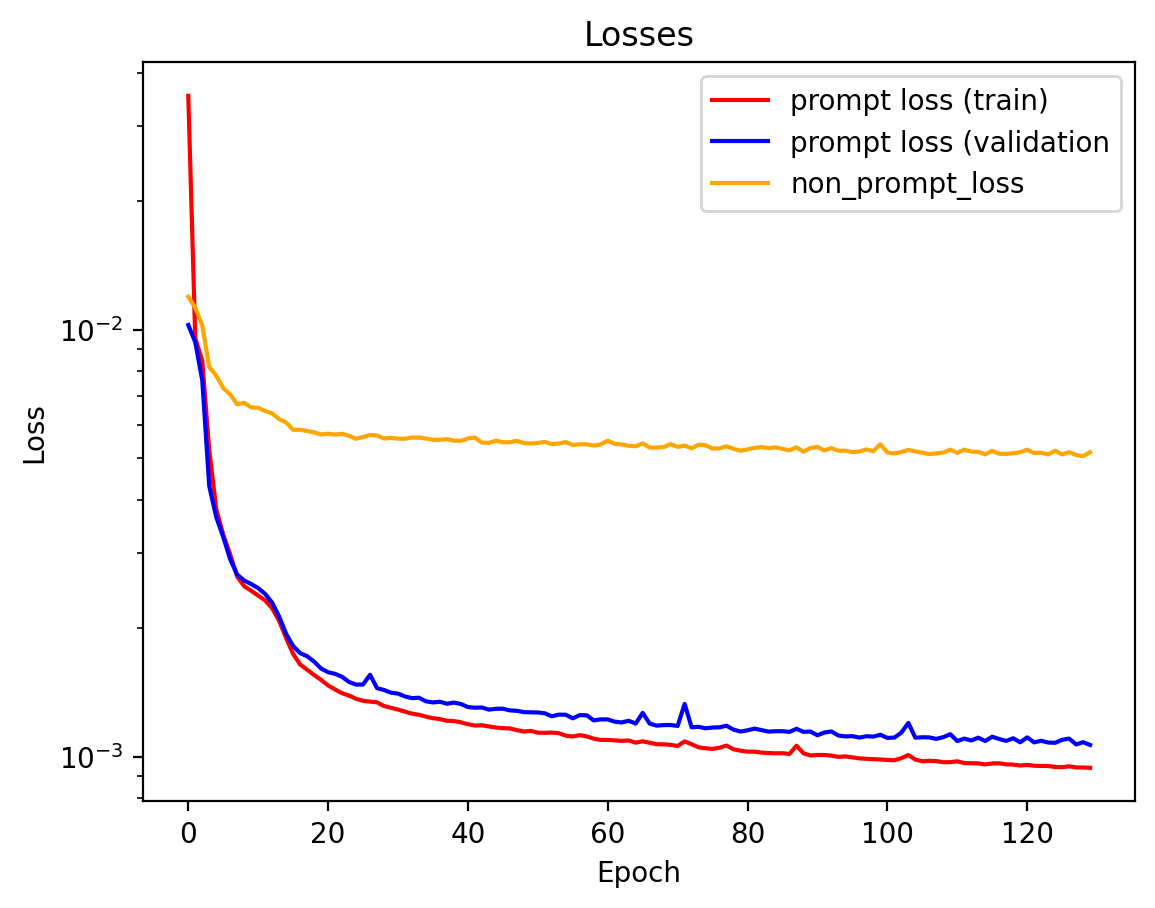

In [21]:
# Training loop with threshold optimization
num_epochs = 200
train_loss = []
val_loss = []
non_prompt_loss = []


for epoch in range(num_epochs):
    enc.train()
    dec.train()
    
    train_batch_loss = []
    val_batch_loss = []
    non_prompt_batch_loss = []

    for inputs, labels in train_loader:
        
        inputs = inputs.view(inputs.size(0), -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
    
        latents = enc(inputs)
        outputs = dec(latents)
    
        loss = loss_fn(inputs, outputs)
        loss.backward()
    
        optimizer_enc.step()
        optimizer_dec.step()
    
        train_batch_loss.append(loss.item())
        
    
    #print(f"epoch: {epoch} loss: {train_loss[-1]}")
    with torch.no_grad():
        enc.eval()
        dec.eval()
        for inputs, _ in test_loader:
            inputs = inputs.view(inputs.size(0), -1)
            inputs = inputs.to(device)
            latents = enc(inputs)
            outputs = dec(latents)
            loss = loss_fn(inputs, outputs)
            val_batch_loss.append(loss.item())
            
    with torch.no_grad():
        enc.eval()
        dec.eval()
        for inputs, _ in non_prompt_loader:
            inputs = inputs.view(inputs.size(0), -1)
            inputs = inputs.to(device)
            latents = enc(inputs)
            outputs = dec(latents)
            loss = loss_fn(inputs, outputs)
            non_prompt_batch_loss.append(loss.item())  
              
            
    train_loss.append(np.mean(train_batch_loss))
    val_loss.append(np.mean(val_batch_loss))
    non_prompt_loss.append(np.mean(non_prompt_batch_loss))
    
    clear_output(wait=True)
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.yscale('log') 
    
    plt.plot(train_loss, c = "Red", label="prompt loss (train)")
    plt.plot(val_loss, c = "Blue", label =  "prompt loss (validation")
    plt.plot(non_prompt_loss, c= "Orange", label =  "non_prompt_loss")
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
torch.save(enc.state_dict(), "../saved_models/enc.pt")
torch.save(dec.state_dict(), "../saved_models/dec.pt")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming enc, dec, loss_fn, non_prompt_loader, test_loader, and device are defined
batch_size = 1  # New batch size

# Create DataLoaders with the new batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
non_prompt_loader = DataLoader(dataset=non_prompt_dataset,  batch_size= batch_size, shuffle= True)

train_loss = []
val_loss = []
non_prompt_loss = []

with torch.no_grad():
    enc.eval()
    dec.eval()
    for inputs, _ in train_loader:
        inputs = inputs.view(inputs.size(0), -1)  # Flatten each input
        inputs = inputs.to(device)
        latents = enc(inputs)
        outputs = dec(latents)
        mse_loss = loss_fn(outputs, inputs)
        train_loss.append(mse_loss.item())
        
with torch.no_grad():
    enc.eval()
    dec.eval()
    for inputs, _ in non_prompt_loader:
        inputs = inputs.view(inputs.size(0), -1)  # Flatten each input
        inputs = inputs.to(device)
        latents = enc(inputs)
        outputs = dec(latents)
        mse_loss = loss_fn(outputs, inputs)
        non_prompt_loss.append(mse_loss.item())

    #print(f'Number of nonprompt errors: {nonprompt_errors}/{total_nonprompt}')

with torch.no_grad():
    enc.eval()
    dec.eval()
    for inputs, _ in test_loader:
        inputs = inputs.view(inputs.size(0), -1)  # Flatten each input
        inputs = inputs.to(device)
        latents = enc(inputs)
        outputs = dec(latents)
        mse_loss = loss_fn(outputs, inputs)
        val_loss.append(mse_loss.item())

    #print(f'Number of prompt errors: {test_errors}/{total_test}')

non_prompt_loss = np.array(non_prompt_loss)
val_loss = np.array(val_loss)
train_loss = np.array(train_loss)

In [ ]:
len(non_prompt_loss)

943

In [ ]:
np.savez('loss_data.npz', train_loss=train_loss, val_loss=val_loss, non_prompt_loss=non_prompt_loss)

In [ ]:
def get_tpr_fpr(threshold):
    tpr = 1 - (len(np.where(non_prompt_loss < threshold)[0]) / len(non_prompt_loss)) if len(non_prompt_loss) > 0 else 0
    fpr = len(np.where(val_loss > threshold)[0]) / len(val_loss) if len(val_loss) > 0 else 0

    return tpr, fpr

(0.0, 0.01)

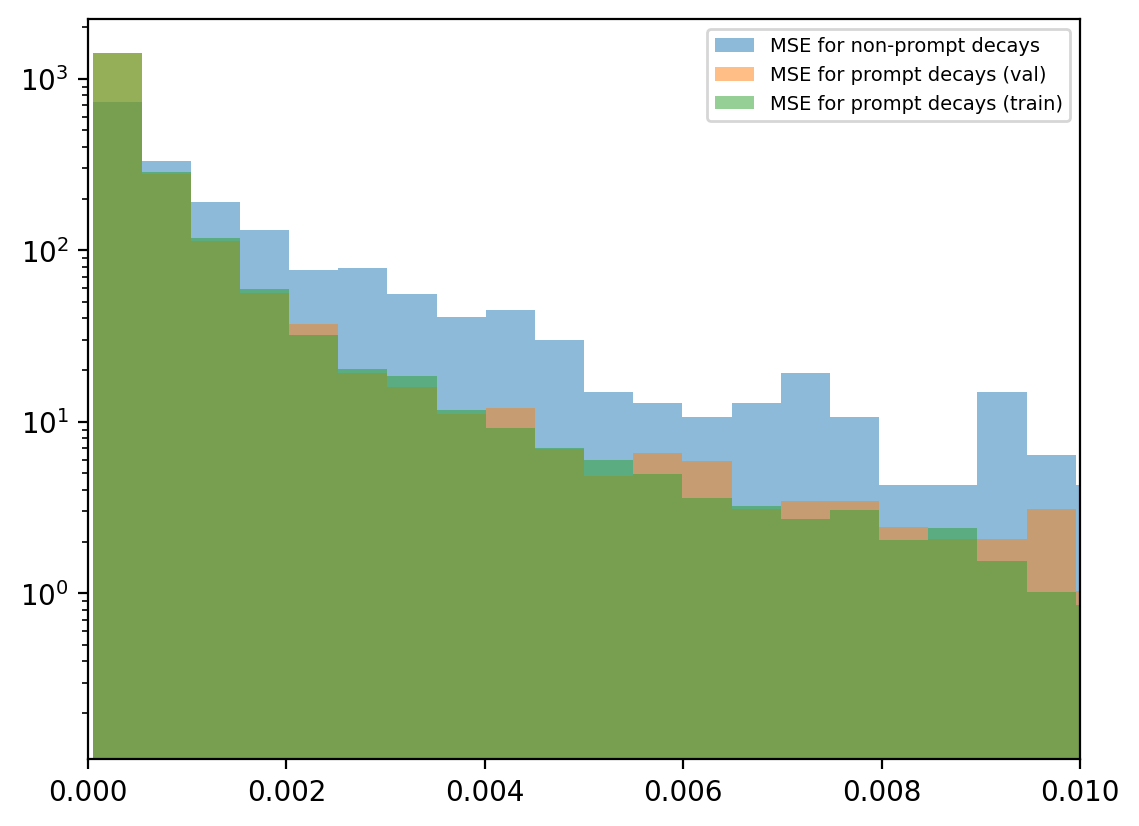

In [ ]:
non_prompt_hist = plt.hist(non_prompt_loss, density=True, bins="auto", alpha=0.5, label= "MSE for non-prompt decays")
_ = plt.hist(val_loss, density=True, bins=non_prompt_hist[1], alpha=0.5, label = "MSE for prompt decays (val)")
_ = plt.hist(train_loss, density=True, bins=non_prompt_hist[1], alpha=0.5, label = "MSE for prompt decays (train)" )

#plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper right", fontsize=7)
plt.xlim(0, 1e-2)

In [ ]:
np.min(non_prompt_loss)

4.472543150768615e-05

100%|██████████| 100000/100000 [00:00<00:00, 242251.10it/s]


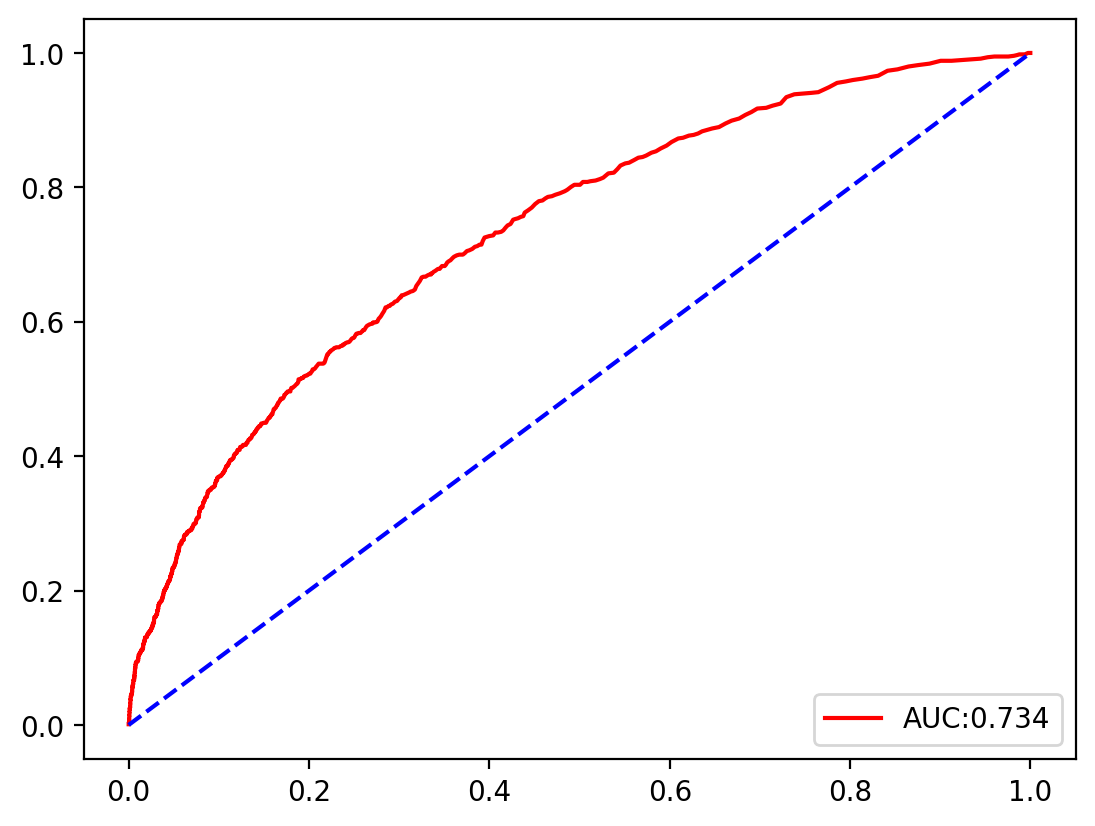

In [ ]:
from tqdm import tqdm
fpr = []
tpr = []
thresholds = np.linspace(np.min([np.min(non_prompt_loss), np.min(val_loss)]), np.max([np.max(non_prompt_loss), np.max(val_loss)]), int(1e+5))
#thresholds = np.logspace(-8, -1, 100000)
#thresholds = np.linspace(1e-5, 1e-2, 100000)

for thr in tqdm(thresholds):
    a , b = get_tpr_fpr(thr)
    tpr.append(a)
    fpr.append(b)

fpr = np.array(fpr)
tpr = np.array(tpr)

auc = 1+np.trapz(fpr, tpr)
plt.plot(fpr, tpr, c="red", ls="-", label=f"AUC:{auc:.3f}")
plt.plot([0,1],[0,1], "b--")
plt.legend(loc="lower right")